# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [28]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.preprocessing import Imputer 
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [29]:
# Load in the general demographics data.
azdias = pd.read_csv ('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv ('AZDIAS_Feature_Summary.csv', sep = ';')

In [30]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print (azdias.shape)
print (feat_info.shape)
display (azdias.head (n=15))

(891221, 85)
(85, 4)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [31]:
# Let's take a look to loaded dataframe of features info from header
display (feat_info.head (n=15))

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [32]:
#number of entries with XX
#display (azdias [azdias.CAMEO_DEU_2015 == 'XX'].shape )

In [33]:
display (azdias.describe ())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


### Observations

From the very first sight it appears that some features contains plenty of unknown or missing values. For example AGER_TYP has at least 75% of lines filled with '-1' which means 75% of data missing/unknown. 
Will prepare a dataset where both naturally missing and unknown/missing values will be marked as NaNs. Based on that will take a decision for dropping certain features. 

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [34]:
#Let's identify naturally missing values (NaNs)

nat_miss = azdias.isnull().sum () 
display (nat_miss)

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

## Observations for feat_info dataframe

It appeared that missing/unknown values were loaded to dataframe as string. However values in AZDIAS stored as float numbers. Hence I cannot compare them and replace float values with NaN unless values in the list provided to df.replace have the same type as float if comparing floats or str if comparing str. Accordingly floats currently saved as str must be converted to float. 

As a first step need to eliminate symbols of '[]' as they do not bring any added value they have been loaded as symbols and are not presented in AZDIAS. 

Second step is to split values as per provided commas, so to make them a list of values and not just a string. For example string '-1,0,9' should be converted to a list of str values: \['-1', '0', '9'\]. 

Then have to convert numeric values like '-1' (str) to -1.0 (float). It should be taken into consideration that not all characters can be converted into float, there are '', 'X' and 'XX' which cannot be converted and they should be left as str in the list.  

In [35]:
"""
Saving here for future use in other projects. Tips from project reviewer of Udacity. 
"""

# turn missing_or_unknown to list 
#feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

# Identify missing or unknown data values and convert them to NaNs.
#for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
#    if missing_values[0] != '':
#        for value in missing_values:
#            if value.isnumeric() or value.lstrip('-').isnumeric():
#                value = int(value)
#            azdias.loc[azdias[attrib] == value, attrib] = np.nan


'\nSaving here for future use in other projects. Tips from project reviewer of Udacity. \n'

In [36]:
#eliminating from the dataframe of feat_info 'X' and 'XX' as both will be eliminated from azdias below

#1 eliminate_char = ['\[', '\]','X','XX']

eliminate_char = ['\[', '\]']

mis_val = feat_info ['missing_or_unknown'].replace (to_replace = eliminate_char, value = '', regex = True)

display (mis_val)

#azdias ['AGER_TYP'].replace (to_replace = mapv ['missing'].tolist (), value = np.NaN, regex = True, inplace = True)
#display (feat_info.iloc [1] ['attribute'])

0       -1,0
1     -1,0,9
2       -1,0
3          0
4         -1
5         -1
6         -1
7         -1
8         -1
9         -1
10        -1
11         0
12          
13          
14      -1,0
15         0
16         0
17         0
18         0
19         0
20         0
21      -1,0
22      -1,0
23         0
24      -1,9
25      -1,9
26      -1,9
27      -1,9
28      -1,9
29      -1,9
       ...  
55        -1
56        -1
57      -1,X
58        XX
59     -1,XX
60        -1
61        -1
62        -1
63        -1
64      -1,0
65      -1,0
66        -1
67        -1
68        -1
69          
70      -1,0
71          
72          
73      -1,0
74          
75        -1
76        -1
77        -1
78        -1
79      -1,0
80        -1
81        -1
82      -1,9
83      -1,0
84      -1,9
Name: missing_or_unknown, Length: 85, dtype: object

In [37]:
#creating new list miss_val that will contain str as a list 
miss_val = []

for item in range (len (mis_val)): 
    miss_val.append (mis_val [item].split (','))
    
display (miss_val)

#display (len (miss_val))
#type (miss_val)

[['-1', '0'],
 ['-1', '0', '9'],
 ['-1', '0'],
 ['0'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['0'],
 [''],
 [''],
 ['-1', '0'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['0'],
 ['-1', '0'],
 ['-1', '0'],
 ['0'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1', '9'],
 ['-1'],
 ['-1'],
 ['-1', '0'],
 ['-1'],
 ['-1', '9'],
 ['0'],
 [''],
 [''],
 ['-1', '0'],
 ['-1'],
 ['-1', '0'],
 ['-1', '0'],
 ['0'],
 [''],
 ['-1', '0'],
 [''],
 ['0'],
 ['-1'],
 ['-1'],
 ['-1', 'X'],
 ['XX'],
 ['-1', 'XX'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1', '0'],
 ['-1', '0'],
 ['-1'],
 ['-1'],
 ['-1'],
 [''],
 ['-1', '0'],
 [''],
 [''],
 ['-1', '0'],
 [''],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1', '0'],
 ['-1'],
 ['-1'],
 ['-1', '9'],
 ['-1', '0'],
 ['-1', '9']]

In [38]:
#mapv = pd.DataFrame (columns = ['missing', 'fake'], data = [['-1', 4], 
                                                          #  ['0', 5]])
#display (mapv)
#l = -2
#print (l in mapv ['missing'])

#list_v = [1,0,-1]

#print (mapv ['missing'].tolist ())

In [39]:
#Eliminating values of XX and X

#1 xx = ['XX', 'X']
#1 azdias.replace (to_replace = xx, value = np.NaN, regex = True, inplace = True)

#checking if applied correctly
#number of entries with XX
#display (azdias [azdias.CAMEO_DEU_2015 == 'XX'].shape )

#eliminating from the list of miss_val



In [40]:
#converting values of miss_val into float where applicable

for item in range (len (miss_val)):
    for j in range (len (miss_val [item])):
        #float cannot convert '', 'X' or 'XX' to float so have to skip it. However we will need it in replacing
        if (miss_val [item] [j] == '' or miss_val [item] [j] == 'X' or miss_val [item] [j] == 'XX'): 
            pass
        else: 
            miss_val [item] [j] = float (miss_val [item] [j]) 

display (miss_val)

[[-1.0, 0.0],
 [-1.0, 0.0, 9.0],
 [-1.0, 0.0],
 [0.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [0.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0, 9.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0, 9.0],
 [0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [0.0],
 [''],
 [-1.0, 0.0],
 [''],
 [0.0],
 [-1.0],
 [-1.0],
 [-1.0, 'X'],
 ['XX'],
 [-1.0, 'XX'],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [''],
 [-1.0, 0.0],
 [''],
 [''],
 [-1.0, 0.0],
 [''],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0],
 [-1.0, 0.0],
 [-1.0],
 [-1.0],
 [-1.0, 9.0],
 [-1.0, 0.0],
 [-1.0, 9.0]]

In [41]:
#filling missing or unknown values with NaN as per the created list miss_val

for item in range (len (miss_val)): 
    column_name = feat_info.iloc [item] ['attribute'] #saving column name
    azdias [column_name].replace (to_replace = miss_val [item], value = np.NaN, regex = True, inplace = True)

In [42]:
# Now let's take a look to the result

display (azdias.head (n=10))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [43]:
#Info about naturally (originally) missing values was saved in nat_miss
#Let's look at "before" and "after"

after_miss_update = azdias.isnull().sum () 

s1 = pd.Series(nat_miss, name='Naturally missing')
s2 = pd.Series(after_miss_update, name='Missing after update')

display (pd.concat([s1, s2], axis=1))

,Naturally missing,Missing after update
AGER_TYP,0,685843
ALTERSKATEGORIE_GROB,0,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,4854
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0
FINANZ_VORSORGER,0,0
FINANZ_ANLEGER,0,0
FINANZ_UNAUFFAELLIGER,0,0
FINANZ_HAUSBAUER,0,0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [44]:
#after_miss_update = azdias.sum () 

number_of_rec = azdias.shape [0]
print (number_of_rec)

#proportion of missing values

#prop_msval = pd.DataFrame(after_miss_update, name='Missing after update')

prop_msval = pd.DataFrame(after_miss_update, columns = ['Missing_after_update'])


prop_msval = prop_msval/(number_of_rec/100)
display (prop_msval)

#display (after_miss_update)

891221


,Missing_after_update
AGER_TYP,76.955435
ALTERSKATEGORIE_GROB,0.323264
ANREDE_KZ,0.000000
CJT_GESAMTTYP,0.544646
FINANZ_MINIMALIST,0.000000
FINANZ_SPARER,0.000000
FINANZ_VORSORGER,0.000000
FINANZ_ANLEGER,0.000000
FINANZ_UNAUFFAELLIGER,0.000000
FINANZ_HAUSBAUER,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8e9d1bf98>]], dtype=object)

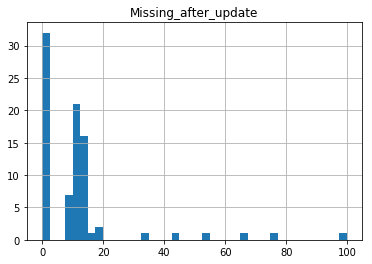

In [45]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
prop_msval.hist (bins = 40)


In [46]:
#Let's take a look to the features that misses more than 10% of data  

prop_msval2 = prop_msval[prop_msval['Missing_after_update'] > 10.0]

display (prop_msval2)


,Missing_after_update
AGER_TYP,76.955435
GEBURTSJAHR,44.020282
HEALTH_TYP,12.476816
LP_LEBENSPHASE_FEIN,10.954859
LP_LEBENSPHASE_GROB,10.611509
NATIONALITAET_KZ,12.153551
PRAEGENDE_JUGENDJAHRE,12.136608
SHOPPER_TYP,12.476816
TITEL_KZ,99.757636
VERS_TYP,12.476816


In [47]:
prop_msval3 = prop_msval2.transpose ()

display (prop_msval3)

,AGER_TYP,GEBURTSJAHR,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,TITEL_KZ,VERS_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
Missing_after_update,76.955435,44.020282,12.476816,10.954859,10.611509,12.153551,12.136608,12.476816,99.757636,12.476816,...,13.073637,13.073637,13.073637,13.073637,13.073637,13.073637,13.073637,10.926022,10.914689,10.926022


<function matplotlib.pyplot.show(*args, **kw)>

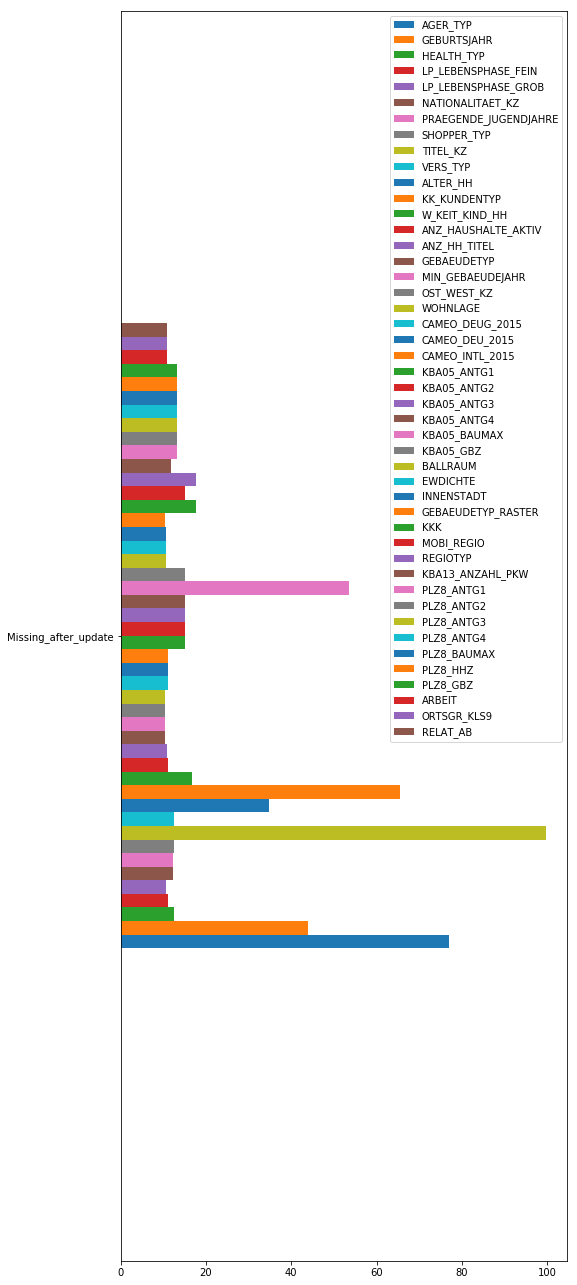

In [48]:
# Investigate patterns in the amount of missing data in each column.
prop_msval3.plot(kind='barh', figsize = (8,23))

plt.show

In [49]:
to_drop = prop_msval[prop_msval['Missing_after_update'] > 20.0]
to_drop = to_drop.transpose ()
display (to_drop)

,AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX
Missing_after_update,76.955435,44.020282,99.757636,34.813699,65.596749,53.468668


## Columns that are outliers in terms of the proportion of values that are missing. 

46 features contains NaN in more than 10% of lines, within these 46 columns there are 6 that are outliers as it is visible from the plot above.

AGER_TYP	    76.95 %
GEBURTSJAHR	    44.02 %
TITEL_KZ	    99.75 %
ALTER_HH	    34.81 %
KK_KUNDENTYP	65.59 %
KBA05_BAUMAX	53.46 %

To be eliminated from the dataset.

In [50]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_new = azdias.drop (to_drop, axis = 1)

#checking if columns were eliminated
print (azdias_new.shape)
display (azdias_new.head (n=10))


(891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [51]:
#Removing dropped features from feat_info as well
feat_info_idx = feat_info.isin (to_drop.columns.values.tolist()) #values that contain features names will be marked as True
#otherwise False

feat_info_new = feat_info.drop (feat_info_idx [feat_info_idx.attribute == True].index) #dropping rows from feat_info where 
# corresponding row of feat_info_idx is equal to True. 

display (feat_info_new) #checking result


,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


In [52]:
#checking patterns for features without missing values. 

display (prop_msval[prop_msval['Missing_after_update'] == 0])


,Missing_after_update
ANREDE_KZ,0.0
FINANZ_MINIMALIST,0.0
FINANZ_SPARER,0.0
FINANZ_VORSORGER,0.0
FINANZ_ANLEGER,0.0
FINANZ_UNAUFFAELLIGER,0.0
FINANZ_HAUSBAUER,0.0
FINANZTYP,0.0
GREEN_AVANTGARDE,0.0
SEMIO_SOZ,0.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

46 features contains NaN in more than 10% of lines, within these 46 columns there are 6 that are outliers as it is visible from the plot above.

AGER_TYP	    76.95 %
GEBURTSJAHR	    44.02 %
TITEL_KZ	    99.75 %
ALTER_HH	    34.81 %
KK_KUNDENTYP	65.59 %
KBA05_BAUMAX	53.46 %

Those 6 were eliminated from the dataset.

FOR THE REMAINING FEATURES, ARE THERE ANY PATTERNS IN WHICH COLUMNS HAVE, OR SHARE, MISSING DATA? 

What columns(names) have same number of missing values?
Following columns have the same number of missing values: 

1. 
LP_FAMILIE_FEIN		77792
LP_FAMILIE_GROB		77792
2. 
LP_STATUS_FEIN		4854
LP_STATUS_GROB		4854
3. 
OST_WEST_KZ		93148
WOHNLAGE		93148
4. 
CAMEO_DEUG_2015		99352
CAMEO_DEU_2015		99352
CAMEO_INTL_2015		99352
5. 
KBA05_ANTG1		133324
KBA05_ANTG2		133324
KBA05_ANTG3		133324
KBA05_ANTG4		133324

Which columns have no missing values?
Following columns have no missing values: 
FINANZ_MINIMALIST	
FINANZ_SPARER	
FINANZ_VORSORGER	
FINANZ_ANLEGER	
FINANZ_UNAUFFAELLIGER	
FINANZ_HAUSBAUER	
FINANZTYP	
SEMIO_SOZ	
SEMIO_FAM	
SEMIO_REL	
SEMIO_MAT	
SEMIO_VERT	
SEMIO_LUST	

Additional thoughts about patterns for missing values:  

1. group #1
GEBAEUDETYP (type of building)	10.451729 %
MIN_GEBAEUDEJAHR (First year building was mentioned in the database)	10.451729%
OST_WEST_KZ (Building location via former East / West Germany)	10.451729% 
WOHNLAGE (Neighborhood quality (or rural flag))	10.451729%
What I can see from above is that all of the questions related to a building and area where this building located. Apparently responders have no enough information about that and answering as unknown to all such questions. 

2. group #2 
CAMEO_DEUG_2015 (Wealth / Life Stage Typology)	11.147852%
CAMEO_DEU_2015 (Wealth / Life Stage Typology, detailed scale)	11.147852%
CAMEO_INTL_2015	(Wealth / Life Stage Typology, mapped to international code) 11.147852%
All of them related to the same subject of life stage typology, hence if not responded to one of them then all affected. 

3. group #3
BALLRAUM (Distance to nearest urban center)	10.518154%
EWDICHTE (Density of households per square kilometer)	10.518154%
INNENSTADT (Distance to city center (downtown))	10.518154%
2 out of 3 related to the same subject. If responders are not able to answer about distance to city/urban center then they likely have no idea about density of households per square kilometer. 

There are other patterns of missing values, the conclusion is that some features either duplicating info or responders may not be aware about certain info and similar/related questions remain not answered.

4. group #4 
No missing values. Basically it is all about personal info like gender, personal typology, financial typology. It is not suprizing since everybody knows own gender, personal character and financial aspect. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [53]:
# How much data is missing in each row of the dataset?
rows_mis = pd.DataFrame (azdias_new.isnull().sum (axis = 1), columns = ['missing_in_rows'])
display (rows_mis.head (n=10))


,missing_in_rows
0,43
1,0
2,0
3,7
4,0
5,0
6,0
7,0
8,0
9,0


In [54]:
rows_mis.describe ()

,missing_in_rows
count,891221.000000
mean,5.649894
std,13.234687
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,49.000000


In [55]:
"""
saving for future use. Advice from project reviewer. 
"""
#plt.figure(figsize=(100,100))
#for i, col in enumerate(azdias.columns[:10]):
#    plt.subplot(5, 2, i+1)
#    sns.distplot(azdias_below[col][azdias_below[col].notnull()], label='below')
#    sns.distplot(azdias_above[col][azdias_above[col].notnull()], label='above')
#    plt.title('Distribution for column: {}'.format(col))
#    plt.legend();

'\nsaving for future use. Advice from project reviewer. \n'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8e9b55978>]], dtype=object)

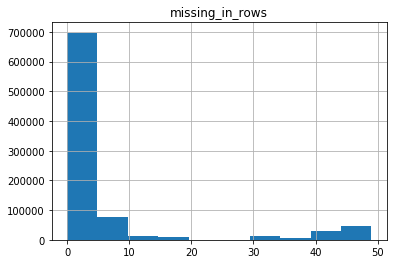

In [56]:
rows_mis.hist ()

In [57]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#first of all let's add a column to the dataset which will contain number of values missing in each row.

azdias_new2 = azdias_new.join (rows_mis) 
display (azdias_new2.head (n=10))


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_in_rows
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0


In [58]:
#Then let's devide dataset based on the number of rows. 
#As it is visible from histogram data can be splitted into 2 subsets: with missing less or equal to 20 values and more than 20. 

azdias_split1 = azdias_new2 [ azdias_new2 ['missing_in_rows'] <=20]

azdias_split2 = azdias_new2 [ azdias_new2 ['missing_in_rows'] >20]

#display (azdias_split1.shape)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8e9c5e358>]], dtype=object)

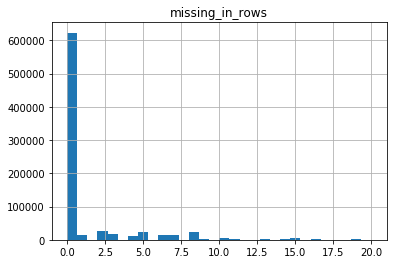

In [59]:
#Let's verify that dataset was correctly splitted. We should see that number of missing values less of equal to 20

azdias_split1.hist (column = 'missing_in_rows', bins = 30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8f6dbd0b8>]], dtype=object)

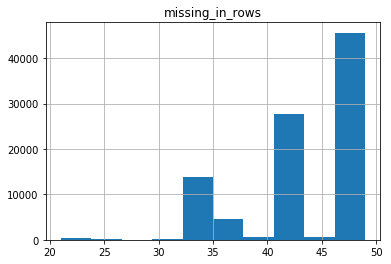

In [60]:
#Let's verify that dataset was correctly splitted. We should see that number of missing values more than 20

azdias_split2.hist (column = 'missing_in_rows')

In [61]:
#defining function to compare missing values in specified column

def comparison_func (df1, df2, column):
    fig, ax =plt.subplots(1,2)
    sns.countplot(df1[column], ax=ax[0])
    sns.countplot(df2[column], ax=ax[1])
    plt.subplots_adjust(wspace= 0.5)
    fig.show()
    return 



/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


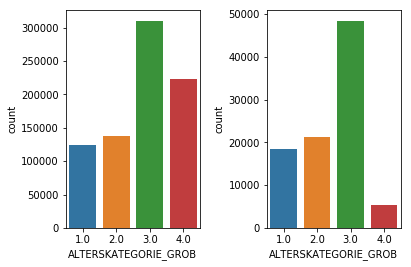

In [62]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

comparison_func (azdias_split1, azdias_split2, 'ALTERSKATEGORIE_GROB')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


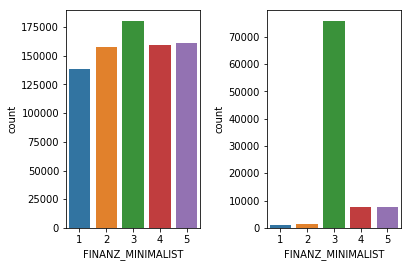

In [63]:
comparison_func (azdias_split1, azdias_split2, 'FINANZ_MINIMALIST')


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


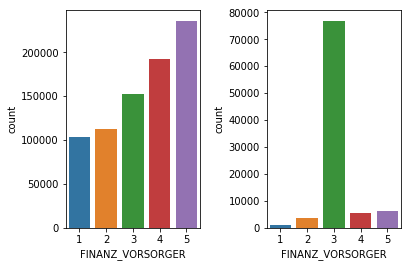

In [64]:
comparison_func (azdias_split1, azdias_split2, 'FINANZ_VORSORGER')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


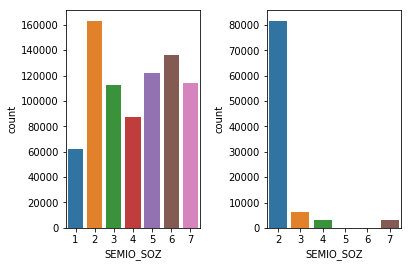

In [65]:
comparison_func (azdias_split1, azdias_split2, 'SEMIO_SOZ')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


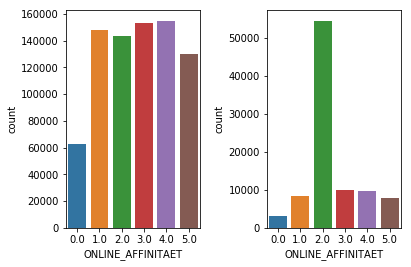

In [66]:
comparison_func (azdias_split1, azdias_split2, 'ONLINE_AFFINITAET')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


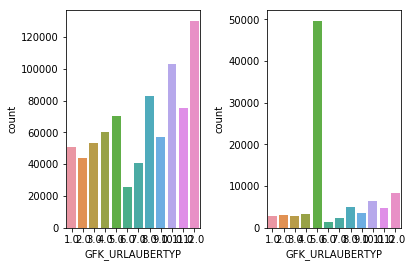

In [67]:
comparison_func (azdias_split1, azdias_split2, 'GFK_URLAUBERTYP')

In [68]:
#dropping rows that contains more than 10 missing values in a row and saving rows which contains 10 or less missing values.
azdias_new3 = azdias_new2 [ azdias_new2 ['missing_in_rows'] <=10]

azdias_new3 = azdias_new3.drop ('missing_in_rows', axis = 1) #we don't need this column anymore.  

#Applying imputation for residual missing values (not more than 10 in a row) using sklearn. Will run it over columns 
#as all values of a feature presented within a single column.

#it did not work "as is" since sklearn imputer cannot replace NaNs of non-numeric columns. 

#Have to apply below custom procedure. 
#Found here https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn

#Non-numeric missing values will be replaced by most frequent, while others will be replaced by median 
#which more suitable since we have many columns with int figures.  

class DFImputer (TransformerMixin):
    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with median values 
        in column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


azdias_new3_im = pd.DataFrame (DFImputer ().fit_transform (azdias_new3)) #preparing new datafram with imputed values.

azdias_new3_im.columns = azdias_new3.columns #restoring column names
azdias_new3_im.index = azdias_new3.index #restoring indeces

azdias_new3 = azdias_new3_im

display (azdias_new3.head (n=10))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2,1.0,2,2,5,3,1,5,6,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.3: Assess Missing Data in Each Row

Dataset can be divided into 2 big subsets: missing less or equal to 20 values in a row and missing more than 20 values in a row where majority is for less than 20.

I have decided that only rows with missing values not more than 10 will be furtherly used in the analysis as more than this thresold might bring false result and bias, since missing in any case should be imputed with other values which were not gathered from the origin. 

I have applied imputation for residual missing values (not more than 10 in a row) using sklearn. Run it over columns 
as all values of a feature presented within a single column.

it did not work "as is" since sklearn imputer cannot replace NaNs of non-numeric columns. I used below custom procedure with minor changes: https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn

Non-numeric missing values will be replaced by most frequent, while others will be replaced by median which more suitable since we have many columns with int figures. I trust median is more suitable here since in the dataset outliers may exist.  

I have also analyzed rows with lots (more than 20) missing values on 6 features with few or now missing values. Intresting finding is that in 5 out of 6 features the data is different comparing to the rows with missing less than 20. This leads to an idea that this subset is special and can be furtherly used in the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [69]:
# How many features are there of each data type?

num_feat = feat_info_new.type.value_counts ()
display (num_feat)

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [70]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_feat = feat_info_new [ feat_info_new ['type'] =='categorical']
display (cat_feat)


,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8ec065940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc8f6e37898>]], dtype=object)

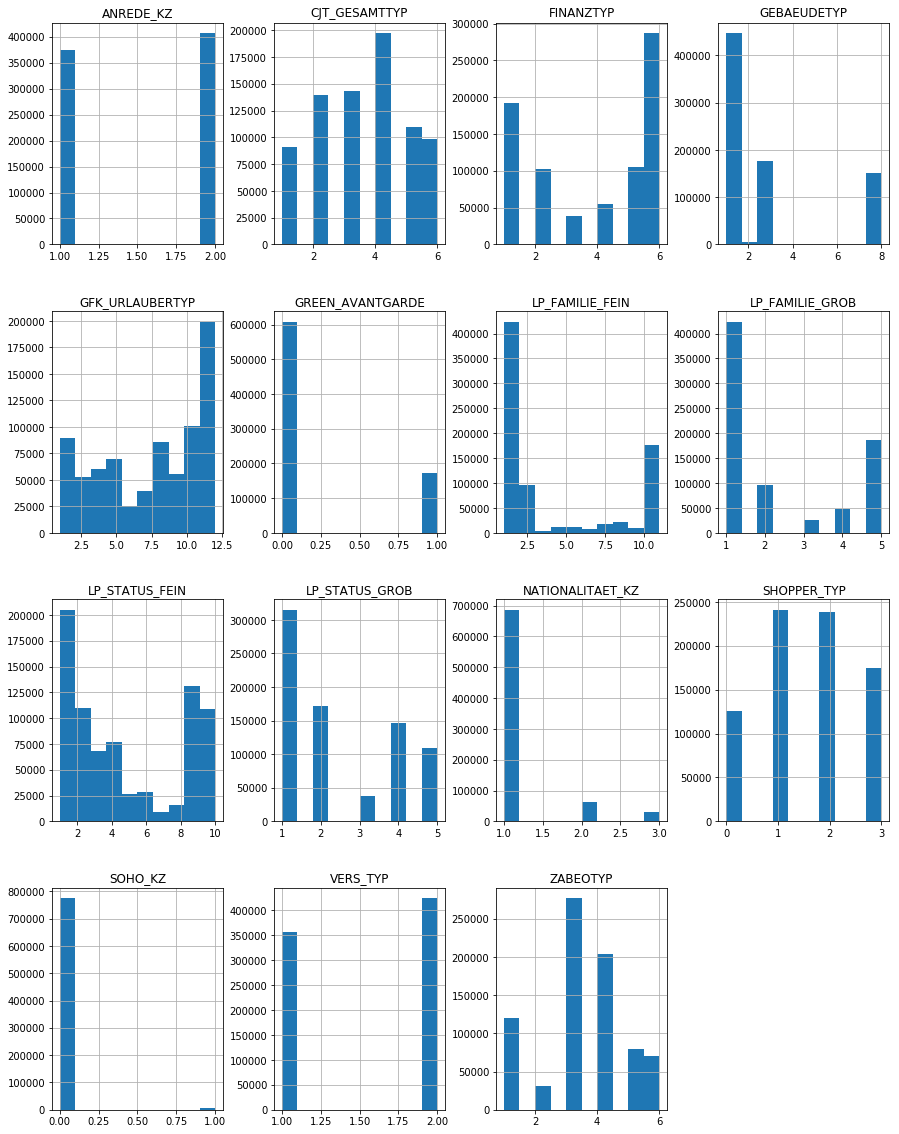

In [71]:
#verufying categorical features 

#***************** 

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
azdias_new3 [cat_feat ['attribute'] ].hist(ax = ax)


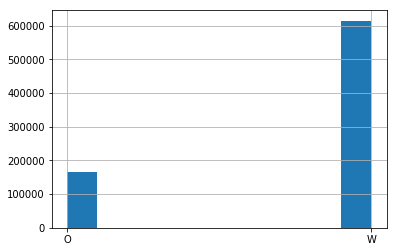

In [72]:
# feature OST_WEST_KZ contains non-numeric values
azdias_new3 ['OST_WEST_KZ'].hist () 

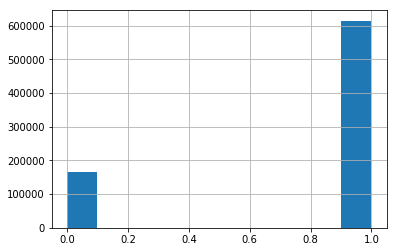

In [73]:
#replacing str 'O' and 'W' with zero and one respectively

#IT DID NOT WORK **************************************
#azdias_new3.loc[azdias_new3['OST_WEST_KZ'] == 'O'] = 0.0
#azdias_new3.loc[azdias_new3['OST_WEST_KZ'] == 'W'] = 1.0

azdias_new3.OST_WEST_KZ = azdias_new3.OST_WEST_KZ.replace ({'O': 0.0,
                                                            'W': 1.0})  

#checking result
azdias_new3 ['OST_WEST_KZ'].hist () 

In [74]:
#preparing a list for get_dummies (one hot encoding)
list_enc = [] 

for column in (cat_feat ['attribute']):
    print (column) #printing feature name
    unv = azdias_new3 [column].unique () #returns list of unique values
    display (unv)
    if unv.size > 2: #we only need features containing more than 2 possible values
        list_enc.append (column)


ANREDE_KZ


array([2, 1])

CJT_GESAMTTYP


array([ 5.,  3.,  2.,  4.,  1.,  6.])

FINANZTYP


array([1, 6, 5, 2, 4, 3])

GFK_URLAUBERTYP


array([ 10.,   1.,   5.,  12.,   9.,   3.,   8.,  11.,   4.,   7.,   2.,
         6.])

GREEN_AVANTGARDE


array([0, 1])

LP_FAMILIE_FEIN


array([  5.,   1.,  10.,   2.,   7.,  11.,   8.,   4.,   6.,   9.,   3.])

LP_FAMILIE_GROB


array([ 3.,  1.,  5.,  2.,  4.])

LP_STATUS_FEIN


array([  2.,   3.,   9.,   4.,   1.,  10.,   5.,   8.,   6.,   7.])

LP_STATUS_GROB


array([ 1.,  2.,  4.,  5.,  3.])

NATIONALITAET_KZ


array([ 1.,  3.,  2.])

SHOPPER_TYP


array([ 3.,  2.,  1.,  0.])

SOHO_KZ


array([ 1.,  0.])

VERS_TYP


array([ 2.,  1.])

ZABEOTYP


array([5, 3, 4, 1, 6, 2])

GEBAEUDETYP


array([ 8.,  1.,  3.,  2.,  6.,  4.,  5.])

OST_WEST_KZ


array([ 1.,  0.])

CAMEO_DEUG_2015


array(['8', '4', '2', '6', '1', '9', '5', '7', '3'], dtype=object)

CAMEO_DEU_2015


array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C', '5A',
       '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D', '8D',
       '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C'], dtype=object)

In [75]:
# Re-encode categorical variable(s) to be kept in the analysis.

#print (azdias_new3 ['OST_WEST_KZ'].unique ().size)
print (list_enc) #for these features we need to apply one hot encoding

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [76]:
azdias_new4 = pd.get_dummies (azdias_new3, columns = list_enc)
print (azdias_new4.shape)
display (list (azdias_new4.columns))

(780153, 194)


['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'P

#### Discussion 1.2.1: Re-Encode Categorical Features

For binary (two-level) categoricals that take numeric values I have kept that as is. 
For one binary variable (OST_WEST_KZ) I have replaced 'O' as 0 and 'W' as '1'. 
For multi-level categoricals (three or more values), I have used OneHotEncoder. 
I have decided not drop features so not to miss any potential prominent variable. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [77]:
#Review mixed type variables

cat_feat_mix = feat_info_new [ feat_info_new ['type'] =='mixed']
display (cat_feat_mix)

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [78]:
# Verifying unique values of mixed type features. 

for column in (cat_feat_mix ['attribute']):
    print (column) #printing feature name
    unv = azdias_new4 [column].unique () #returns list of unique values
    display (unv)

LP_LEBENSPHASE_FEIN


array([ 21.,   3.,  13.,  32.,   8.,   2.,   5.,  10.,   4.,   6.,  23.,
        12.,  20.,   1.,  25.,  18.,  31.,  38.,  35.,  30.,   7.,  22.,
        14.,  29.,  24.,  28.,  37.,  26.,  39.,  27.,  36.,   9.,  34.,
        33.,  15.,  11.,  40.,  16.,  19.,  17.])

LP_LEBENSPHASE_GROB


array([  6.,   1.,   3.,  10.,   2.,   5.,   7.,  12.,  11.,   9.,   4.,
         8.])

PRAEGENDE_JUGENDJAHRE


array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,   2.,
         1.,  12.,  13.,   7.])

WOHNLAGE


array([ 4.,  2.,  7.,  3.,  5.,  1.,  8.,  0.])

CAMEO_INTL_2015


array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

PLZ8_BAUMAX


array([ 1.,  2.,  4.,  5.,  3.])

## Mixed type features 

1. PRAEGENDE_JUGENDJAHRE - re-encoded below.
2. CAMEO_INTL_2015 - re-encoded below.
3. LP_LEBENSPHASE_FEIN (life stage, fine scale) - contains multiple slices of person and social status like: single/couple/family, income, age, homeowners, single parent. From presented possible values it is impossible to generate for each and every slice a feature that would certainly contain a value, not NaN. However it is useful to keep this feature as it might overlap with customer data.
4. LP_LEBENSPHASE_GROB (life stage, rough scale)- pretty similar to LP_LEBENSPHASE_FEIN, where it is rough scale. All the arguments the same here: contains multiple slices of person and social status like single/couple/family, income, age, homeowners, single parent. From presented possible values it is impossible to generate for each and every slice a feature that would certainly contain a value, not NaN. However it is useful to keep this feature as it might overlap with customer data.
5. WOHNLAGE (neighborhood) - I decided to drop this feature as possible values are mixed, not categorical and as per PCA analysis this feature plays very minor role (previously I kept it). 
6. PLZ8_BAUMAX (building) - I decided to drop this feature as it is not categorical and almost fully covered from PLZ8_ANTG1 to PLZ8_ANTG4 except for commercial buildings which should not play major role in the analysis. 


In [79]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#it appears that "PRAEGENDE_JUGENDJAHRE" should be devided into 2 variables: first will stand for decade, e.g. 40s, 50s, etc.
#second will be for Avantgarde vs. Mainstream

#Let's copy column "PRAEGENDE_JUGENDJAHRE" to new columns: PRAEGENDE_JUGENDJAHRE_AM (Avantgarde vs. Mainstream) 
#and PRAEGENDE_JUGENDJAHRE_DC (Decades)

#Original PRAEGENDE_JUGENDJAHRE values will be dropped later on. 

azdias_new4 ['PRAEGENDE_JUGENDJAHRE_AM'] = azdias_new4 ['PRAEGENDE_JUGENDJAHRE']

azdias_new4 ['PRAEGENDE_JUGENDJAHRE_DC'] = azdias_new4 ['PRAEGENDE_JUGENDJAHRE']


In [80]:
# Let's encode PRAEGENDE_JUGENDJAHRE and PRAEGENDE_JUGENDJAHRE_AM

dict1 =                                                                        {1: 40.0,
                                                                                2: 40.0,
                                                                                3: 50.0,
                                                                                4: 50.0,
                                                                                5: 60.0,
                                                                                6: 60.0,
                                                                                7: 60.0,
                                                                                8: 70.0,
                                                                                9: 70.0,
                                                                                10: 80.0,
                                                                                11: 80.0,
                                                                                12: 80.0,
                                                                                13: 80.0,
                                                                                14: 90.0, 
                                                                                15: 90.0,
                                                                                }


#replacing with decade values
azdias_new4.PRAEGENDE_JUGENDJAHRE_DC = azdias_new4.PRAEGENDE_JUGENDJAHRE_DC.replace (dict1)  


#replacing where Mainstream encoded as 0 and avantgarde as 1
dict2 =                                                                        {1: 0.0,
                                                                                2: 1.0,
                                                                                3: 0.0,
                                                                                4: 1.0,
                                                                                5: 0.0,
                                                                                6: 1.0,
                                                                                7: 1.0,
                                                                                8: 0.0,
                                                                                9: 1.0,
                                                                                10: 0.0,
                                                                                11: 1.0,
                                                                                12: 0.0,
                                                                                13: 1.0,
                                                                                14: 0.0, 
                                                                                15: 1.0,
                                                                                }

azdias_new4.PRAEGENDE_JUGENDJAHRE_AM = azdias_new4.PRAEGENDE_JUGENDJAHRE_AM.replace (dict2)  
#display (azdias_new4.head (n=10))

In [81]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#It appears that "CAMEO_INTL_2015" should be devided into 2 variables: wealth and life stage

#Wealth can be coded as (in the new column CAMEO_INTL_2015_WL): 
#Wealthy Households: 1
#Prosperous Households: 2
#Comfortable Households: 3
#Less Affluent Households: 4
#Poorer Households: 5

#Life stage as (in new column CAMEO_INTL_2015_LS): 
#Pre-Family: 0
#Young Couples: 1
#Families: 2
#Older Families: 3 
#Elders: 4

#Let's copy column "CAMEO_INTL_2015" to a new column: CAMEO_INTL_2015_LS
azdias_new4 ['CAMEO_INTL_2015_LS'] = azdias_new4 ['CAMEO_INTL_2015']
azdias_new4 ['CAMEO_INTL_2015_WL'] = azdias_new4 ['CAMEO_INTL_2015']


In [82]:
# Encoding CAMEO_INTL_2015 and CAMEO_INTL_2015_LS

# ************** numbers were as str and not int so could not convert from 1st attempt. 

#replacing with wealth codes
dict3 = {'11': 1.0,
                                                                                '12': 1.0,
                                                                                '13': 1.0,
                                                                                '14': 1.0,
                                                                                '15': 1.0,
                                                                                '21': 2.0,
                                                                                '22': 2.0,
                                                                                '23': 2.0,
                                                                                '24': 2.0,
                                                                                '25': 2.0,
                                                                                '31': 3.0,
                                                                                '32': 3.0,
                                                                                '33': 3.0,
                                                                                '34': 3.0, 
                                                                                '35': 3.0,
                                                                                '41': 4.0,
                                                                                '42': 4.0,
                                                                                '43': 4.0,
                                                                                '44': 4.0, 
                                                                                '45': 4.0,
                                                                                '51': 5.0,
                                                                                '52': 5.0,
                                                                                '53': 5.0,
                                                                                '54': 5.0, 
                                                                                '55': 5.0,                                                                        
                                                                                                                                                              
                                                                                }

azdias_new4.CAMEO_INTL_2015_WL = azdias_new4.CAMEO_INTL_2015_WL.replace (dict3)  

#replacing values for family life stage
dict4 = {'11': 1.0,
                                                                                '12': 2.0,
                                                                                '13': 3.0,
                                                                                '14': 4.0,
                                                                                '15': 5.0,
                                                                                '21': 1.0,
                                                                                '22': 2.0,
                                                                                '23': 3.0,
                                                                                '24': 4.0,
                                                                                '25': 5.0,
                                                                                '31': 1.0,
                                                                                '32': 2.0,
                                                                                '33': 3.0,
                                                                                '34': 4.0, 
                                                                                '35': 5.0,
                                                                                '41': 1.0,
                                                                                '42': 2.0,
                                                                                '43': 3.0,
                                                                                '44': 4.0, 
                                                                                '45': 5.0,
                                                                                '51': 1.0,
                                                                                '52': 2.0,
                                                                                '53': 3.0,
                                                                                '54': 4.0, 
                                                                                '55': 5.0,                                                                        
                                                                                                                                                              
                                                                                }
azdias_new4.CAMEO_INTL_2015_LS = azdias_new4.CAMEO_INTL_2015_LS.replace (dict4)  

In [83]:
#checking if applied.
#display (azdias_new4 ['CAMEO_INTL_2015'].head (n=10))

#### Discussion 1.2.2: Engineer Mixed-Type Features

PRAEGENDE_JUGENDJAHRE - re-encoded above.

It appeared that "PRAEGENDE_JUGENDJAHRE" should be devided into 2 variables: first will stand for decade, e.g. 40s, 50s, etc.
second will be for Avantgarde vs. Mainstream
I have copied column "PRAEGENDE_JUGENDJAHRE" to new columns: PRAEGENDE_JUGENDJAHRE_AM (Avantgarde vs. Mainstream) 
and PRAEGENDE_JUGENDJAHRE_DC (Decades)
Original PRAEGENDE_JUGENDJAHRE values will be dropped. 

CAMEO_INTL_2015 - re-encoded above.
It appeared that "CAMEO_INTL_2015" should be devided into 2 variables: wealth and life stage

Wealth can be coded as (in the new column CAMEO_INTL_2015_WL): 
Wealthy Households: 1
Prosperous Households: 2
Comfortable Households: 3
Less Affluent Households: 4
Poorer Households: 5

Life stage as (in new column CAMEO_INTL_2015_LS): 
Pre-Family: 0
Young Couples: 1
Families: 2
Older Families: 3 
Elders: 4

LP_LEBENSPHASE_FEIN (life stage, fine scale) - contains multiple slices of person and social status like: single/couple/family, income, age, homeowners, single parent. From presented possible values it is impossible to generate for each and every slice a feature that would certainly contain a value, not NaN. However it is useful to keep this feature as it might overlap with customer data.

LP_LEBENSPHASE_GROB (life stage, rough scale)- pretty similar to LP_LEBENSPHASE_FEIN, where it is rough scale. All the arguments the same here: contains multiple slices of person and social status like single/couple/family, income, age, homeowners, single parent. From presented possible values it is impossible to generate for each and every slice a feature that would certainly contain a value, not NaN. However it is useful to keep this feature as it might overlap with customer data.

WOHNLAGE (neighborhood) - I decided to drop this feature as possible values are mixed, not categorical and as per PCA analysis this feature plays very minor role (previously I kept it). 

PLZ8_BAUMAX (building) - I decided to drop this feature as it is not categorical and almost fully covered from PLZ8_ANTG1 to PLZ8_ANTG4 except for commercial buildings which should not play major role in the analysis. 


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [84]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#All re-engineering tasks applied.

In [85]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#dropping columns that were substituted by new features and the features decided to be dropped.
azdias_new4.drop (['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis = 1, inplace = True)

display (azdias_new4.head (n=10))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0.0,90.0,1.0,5.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,1.0,90.0,4.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,70.0,2.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0.0,70.0,3.0,4.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0.0,50.0,4.0,5.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,0.0,80.0,2.0,2.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0,0,0,0,0,0,0.0,70.0,4.0,1.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,0,0,0,0,0,0,1.0,80.0,3.0,1.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,0,0,0,0,0,0,1.0,90.0,5.0,1.0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,0,0,0,0,1,0,0.0,50.0,1.0,5.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [86]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame, number of dropped rows, 
    number of rows in the dataset before dropping rows with missing values, indeces of dataframe before dropping rows, 
    dataframe of rows that contains more than 10 missing values in a row.
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    #filling missing or unknown values with NaN as per the created list miss_val
    cl_df = df
    for item in range (len (miss_val)): 
        column_name = feat_info.iloc [item] ['attribute'] #saving column name
        cl_df[column_name].replace (to_replace = miss_val [item], value = np.NaN, regex = True, inplace = True)
    
    #dropping outlier columns in terms of missing values, more than 20%
    cl_df1 = cl_df.drop (to_drop, axis = 1)
        
    #adding a column reflecting missing values in each row respectively
    rows_mis = pd.DataFrame (cl_df1.isnull().sum (axis = 1), columns = ['missing_in_rows'])
    cl_df2 = cl_df1.join (rows_mis) 
          
    #dropping rows that contains more than 10 missing values in a row and saving rows which contains 10 or less missing values.
    cl_df3 = cl_df2 [ cl_df2 ['missing_in_rows'] <=10]
    
    #storing dataframe of rows that contains more than 10 missing values in a row.
    cl_df_more_than_10 = cl_df2 [ cl_df2 ['missing_in_rows'] >10]
    cl_df_more_than_10.columns = cl_df2.columns
    cl_df_more_than_10 = cl_df_more_than_10.drop ('missing_in_rows', axis = 1) #we don't need this column anymore.  
    
    
    #storing number of dropped rows and returining from function
    drop_rows = cl_df2 [ cl_df2 ['missing_in_rows'] >10].shape [0]
    
    #storing number of rows (including with missing values)
    rows_number = cl_df2.shape [0]
    
    #storing indeces
    index = cl_df3.index
    
    cl_df3 = cl_df3.drop ('missing_in_rows', axis = 1) #we don't need this column anymore.  

    #Applying imputation for residual missing values (not more than 10 in a row) using sklearn. Will run it over columns 
    #as all values of a feature presented within a single column.

    cl_df3_im = pd.DataFrame (DFImputer ().fit_transform (cl_df3)) #preparing new datafram with imputed values.
    cl_df3_im.columns = cl_df3.columns #restoring column names
    cl_df3_im.index = cl_df3.index #restoring indeces
    cl_df3 = cl_df3_im #saving result

    #print (cl_df3.shape)
    #encoding features
    cl_df3.OST_WEST_KZ = cl_df3.OST_WEST_KZ.replace ({'O': 0.0,
                                                      'W': 1.0})  
    cl_df4 = pd.get_dummies (cl_df3, columns = list_enc)
    
    #print (cl_df4.shape)
    
    cl_df4 ['PRAEGENDE_JUGENDJAHRE_AM'] = cl_df4 ['PRAEGENDE_JUGENDJAHRE']
    cl_df4 ['PRAEGENDE_JUGENDJAHRE_DC'] = cl_df4 ['PRAEGENDE_JUGENDJAHRE']
    
    cl_df4.PRAEGENDE_JUGENDJAHRE_DC = cl_df4.PRAEGENDE_JUGENDJAHRE_DC.replace (dict1)  
    cl_df4.PRAEGENDE_JUGENDJAHRE_AM = cl_df4.PRAEGENDE_JUGENDJAHRE_AM.replace (dict2)  

    cl_df4 ['CAMEO_INTL_2015_LS'] = cl_df4 ['CAMEO_INTL_2015']
    cl_df4 ['CAMEO_INTL_2015_WL'] = cl_df4 ['CAMEO_INTL_2015']
    
    cl_df4.CAMEO_INTL_2015_WL = cl_df4.CAMEO_INTL_2015_WL.replace (dict3)  
    cl_df4.CAMEO_INTL_2015_LS = cl_df4.CAMEO_INTL_2015_LS.replace (dict4)   
        
    cl_df4.drop (['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis = 1, inplace = True)
    
    # Return the cleaned dataframe and other data.
    return cl_df4, drop_rows, rows_number, index, cl_df_more_than_10
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [87]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#NaNs cleaned above.

In [88]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler () 
azdias5 = pd.DataFrame (scaler.fit_transform (azdias_new4))

azdias5.columns = azdias_new4.columns #restoring column names
azdias5.index = azdias_new4.index #restoring indeces

display (azdias5.head (n=10)) #verifying result


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL
1,-1.767651,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.088920,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.583521,1.176156,-1.249732,1.170995
2,0.198089,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.088920,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,1.713734,1.176156,0.763856,-0.874275
3,1.180959,0.958395,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.263472,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.583521,-0.217966,-0.578536,-1.556031
4,0.198089,-1.043411,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.088920,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.583521,-0.217966,0.092660,0.489238
5,-1.767651,0.958395,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.088920,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.583521,-1.612088,0.763856,1.170995
6,-0.784781,0.958395,-1.488140,1.539080,-1.771610,1.467273,0.980071,-0.102971,-0.531199,-0.263472,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.583521,0.479095,-0.578536,-0.874275
7,-1.767651,-1.043411,-0.036761,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,-1.615864,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,-0.583521,-0.217966,0.763856,-1.556031
8,0.198089,-1.043411,0.688928,0.866538,-1.045251,0.788502,-0.454983,-0.817895,1.882535,1.088920,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,1.713734,0.479095,0.092660,-1.556031
9,0.198089,0.958395,-0.762450,0.866538,-1.045251,0.109731,1.697599,0.611953,1.882535,-0.263472,...,-0.151267,-0.163813,-0.191144,-0.181397,-0.194377,-0.08919,1.713734,1.176156,1.435052,-1.556031
10,0.198089,0.958395,-0.762450,-0.478545,1.133828,0.109731,-1.172510,1.326876,-0.531199,-0.263472,...,-0.151267,-0.163813,-0.191144,-0.181397,5.144636,-0.08919,-0.583521,-1.612088,-1.249732,1.170995


### Discussion 2.1: Apply Feature Scaling


#### Decision about rows to be taken for further analysis and eliminating NaNs.
If I drop all rows with NaNs then number of rows would be 623209 which is about 70% from the original dataset.
On the contrary if I replace with most_requent and median NaNs in condition it is missing not more than 10 values per row, then 
I can use 780153 rows which is 87% percent from the original dataset. 
In this case I decide to save these rows and use more data that could be useful and indicative for the project.

#### Features scaling

I have applied standard scaler to the dataset after dropping columns, rows and imputting missing values.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [89]:
#Defining functions provided during the course: 

def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [90]:
# Apply PCA to the data.

pca = PCA (n_components = 100)
azdias5_pca = pca.fit_transform (azdias5)

#display (azdias5_pca.head (n=10))

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL
Dimension 1,0.0815,-0.0774,0.0141,-0.1856,0.1076,-0.0781,0.0491,0.0473,0.1485,-0.1046,...,0.0255,0.0363,0.0558,0.0568,0.0563,0.0174,-0.0886,0.0653,-0.1070,0.1812
Dimension 2,0.0576,0.2354,0.0387,0.0948,-0.2293,0.2204,-0.2040,-0.2142,0.0796,-0.0043,...,0.0335,-0.0087,-0.0002,0.0041,0.0100,0.0381,0.0013,-0.2400,0.0160,0.0486
Dimension 3,0.0352,0.0168,-0.3461,0.1298,-0.0567,0.0478,-0.1534,-0.0480,-0.0617,0.0706,...,0.0006,-0.0039,0.0128,0.0254,0.0118,-0.0010,0.0559,-0.0500,-0.0155,0.0191
Dimension 4,0.0297,0.0065,0.0607,-0.0072,-0.0046,0.0104,-0.0473,0.0018,0.0043,0.1684,...,0.0017,0.0230,0.0112,0.0158,0.0117,0.0067,0.1614,0.0070,-0.0103,0.0178
Dimension 5,0.0239,0.0502,-0.0585,0.0184,-0.0288,0.0387,0.0501,-0.1131,0.0132,-0.2685,...,0.0346,0.0505,0.0319,0.0121,0.0204,-0.0047,-0.2659,-0.0348,-0.0713,0.1383
Dimension 6,0.0159,0.0040,0.0023,-0.1274,0.0082,0.0292,0.0194,0.0217,0.1939,-0.0309,...,0.0092,-0.0426,-0.0739,-0.0639,-0.0691,0.0215,-0.0140,-0.0289,0.0631,0.0110
Dimension 7,0.0149,0.0156,0.0078,0.0690,-0.0173,-0.0390,-0.0162,-0.0253,-0.1184,-0.0545,...,-0.0655,-0.0028,0.0466,0.0623,0.0239,0.0685,-0.0573,0.0306,-0.0791,-0.0613
Dimension 8,0.0134,0.0026,-0.0122,0.0491,-0.0403,-0.0228,-0.0433,-0.0368,-0.0502,-0.0115,...,0.0553,-0.0767,-0.0770,-0.0912,-0.1113,-0.0505,-0.0405,0.0184,0.1244,0.0159
Dimension 9,0.0130,-0.0451,0.0322,-0.0330,0.0281,-0.0788,0.0975,-0.0498,0.1025,0.0266,...,0.0900,-0.0079,0.0408,0.0036,-0.0268,0.0385,0.0332,-0.0033,0.2255,-0.0587
Dimension 10,0.0127,0.0030,-0.0033,-0.0602,0.0088,0.0581,0.0097,0.0211,0.0845,-0.0433,...,-0.0176,0.0625,0.0272,0.0392,0.0507,0.0634,-0.0217,-0.0352,-0.0133,-0.0507


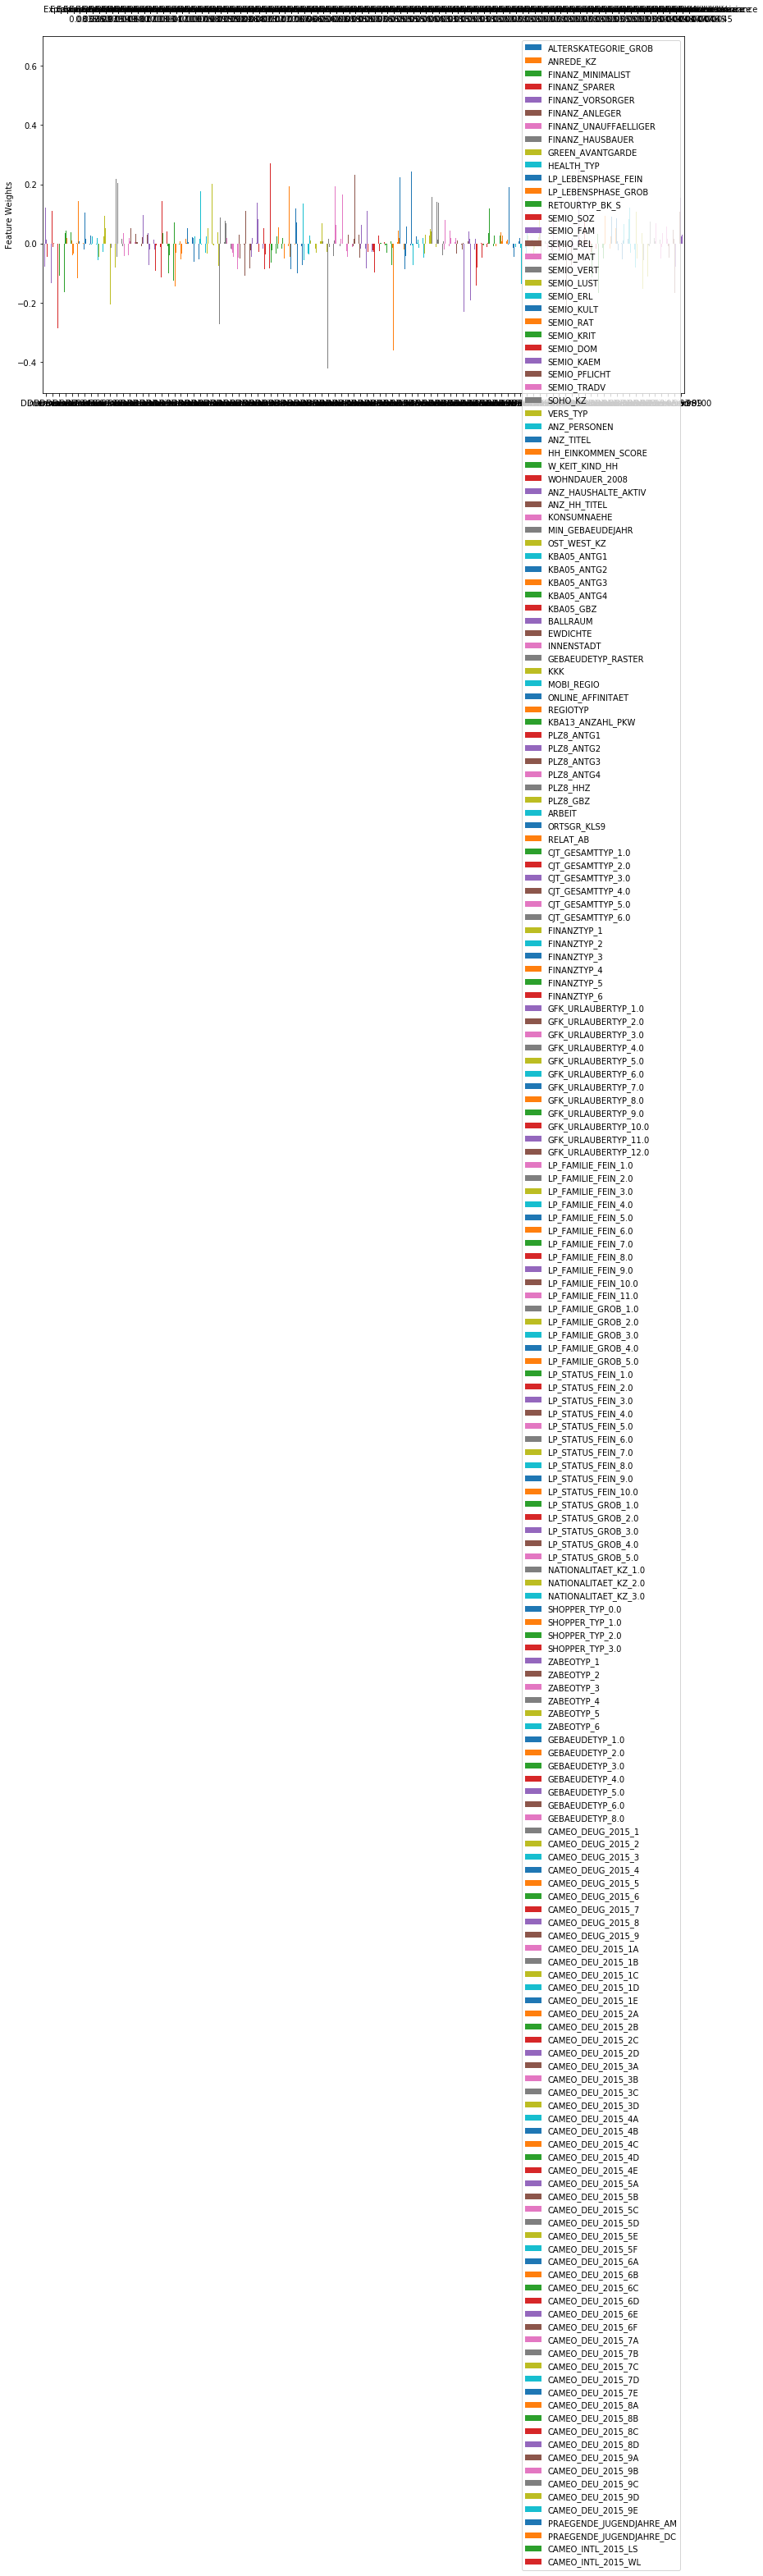

In [91]:
# Investigate the variance accounted for by each principal component.

pca_results (azdias5, pca)


,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL
Dimension 1,0.0815,-0.0774,0.0141,-0.1856,0.1076,-0.0781,0.0491,0.0473,0.1485,-0.1046,...,0.0255,0.0363,0.0558,0.0568,0.0563,0.0174,-0.0886,0.0653,-0.1070,0.1812
Dimension 2,0.0576,0.2354,0.0387,0.0948,-0.2293,0.2204,-0.2040,-0.2142,0.0796,-0.0043,...,0.0335,-0.0087,-0.0002,0.0041,0.0100,0.0380,0.0013,-0.2400,0.0160,0.0486
Dimension 3,0.0352,0.0168,-0.3461,0.1298,-0.0567,0.0478,-0.1534,-0.0480,-0.0617,0.0706,...,0.0005,-0.0039,0.0128,0.0254,0.0117,-0.0010,0.0558,-0.0500,-0.0155,0.0190
Dimension 4,0.0297,0.0066,0.0607,-0.0072,-0.0046,0.0104,-0.0473,0.0019,0.0042,0.1685,...,0.0017,0.0231,0.0111,0.0160,0.0117,0.0068,0.1616,0.0071,-0.0103,0.0180
Dimension 5,0.0239,0.0501,-0.0586,0.0182,-0.0286,0.0387,0.0501,-0.1127,0.0128,-0.2680,...,0.0349,0.0504,0.0312,0.0125,0.0200,-0.0044,-0.2656,-0.0346,-0.0709,0.1388
Dimension 6,0.0159,0.0048,0.0022,-0.1278,0.0088,0.0293,0.0194,0.0228,0.1947,-0.0300,...,0.0063,-0.0406,-0.0716,-0.0608,-0.0709,0.0240,-0.0118,-0.0292,0.0615,0.0137
Dimension 7,0.0149,0.0143,0.0078,0.0682,-0.0172,-0.0378,-0.0163,-0.0249,-0.1170,-0.0520,...,-0.0666,0.0001,0.0465,0.0623,0.0242,0.0683,-0.0547,0.0295,-0.0781,-0.0588
Dimension 8,0.0133,0.0078,-0.0138,0.0397,-0.0359,-0.0261,-0.0406,-0.0272,-0.0408,-0.0100,...,0.0565,-0.0727,-0.0695,-0.0915,-0.1216,-0.0428,-0.0355,0.0174,0.1400,0.0090
Dimension 9,0.0130,-0.0438,0.0326,-0.0357,0.0299,-0.0781,0.1017,-0.0514,0.1050,0.0239,...,0.0856,-0.0007,0.0409,0.0065,-0.0211,0.0407,0.0321,-0.0047,0.2263,-0.0657
Dimension 10,0.0126,-0.0001,-0.0017,-0.0581,0.0108,0.0567,0.0137,0.0198,0.0812,-0.0386,...,-0.0169,0.0724,0.0301,0.0478,0.0675,0.0693,-0.0158,-0.0343,-0.0186,-0.0394


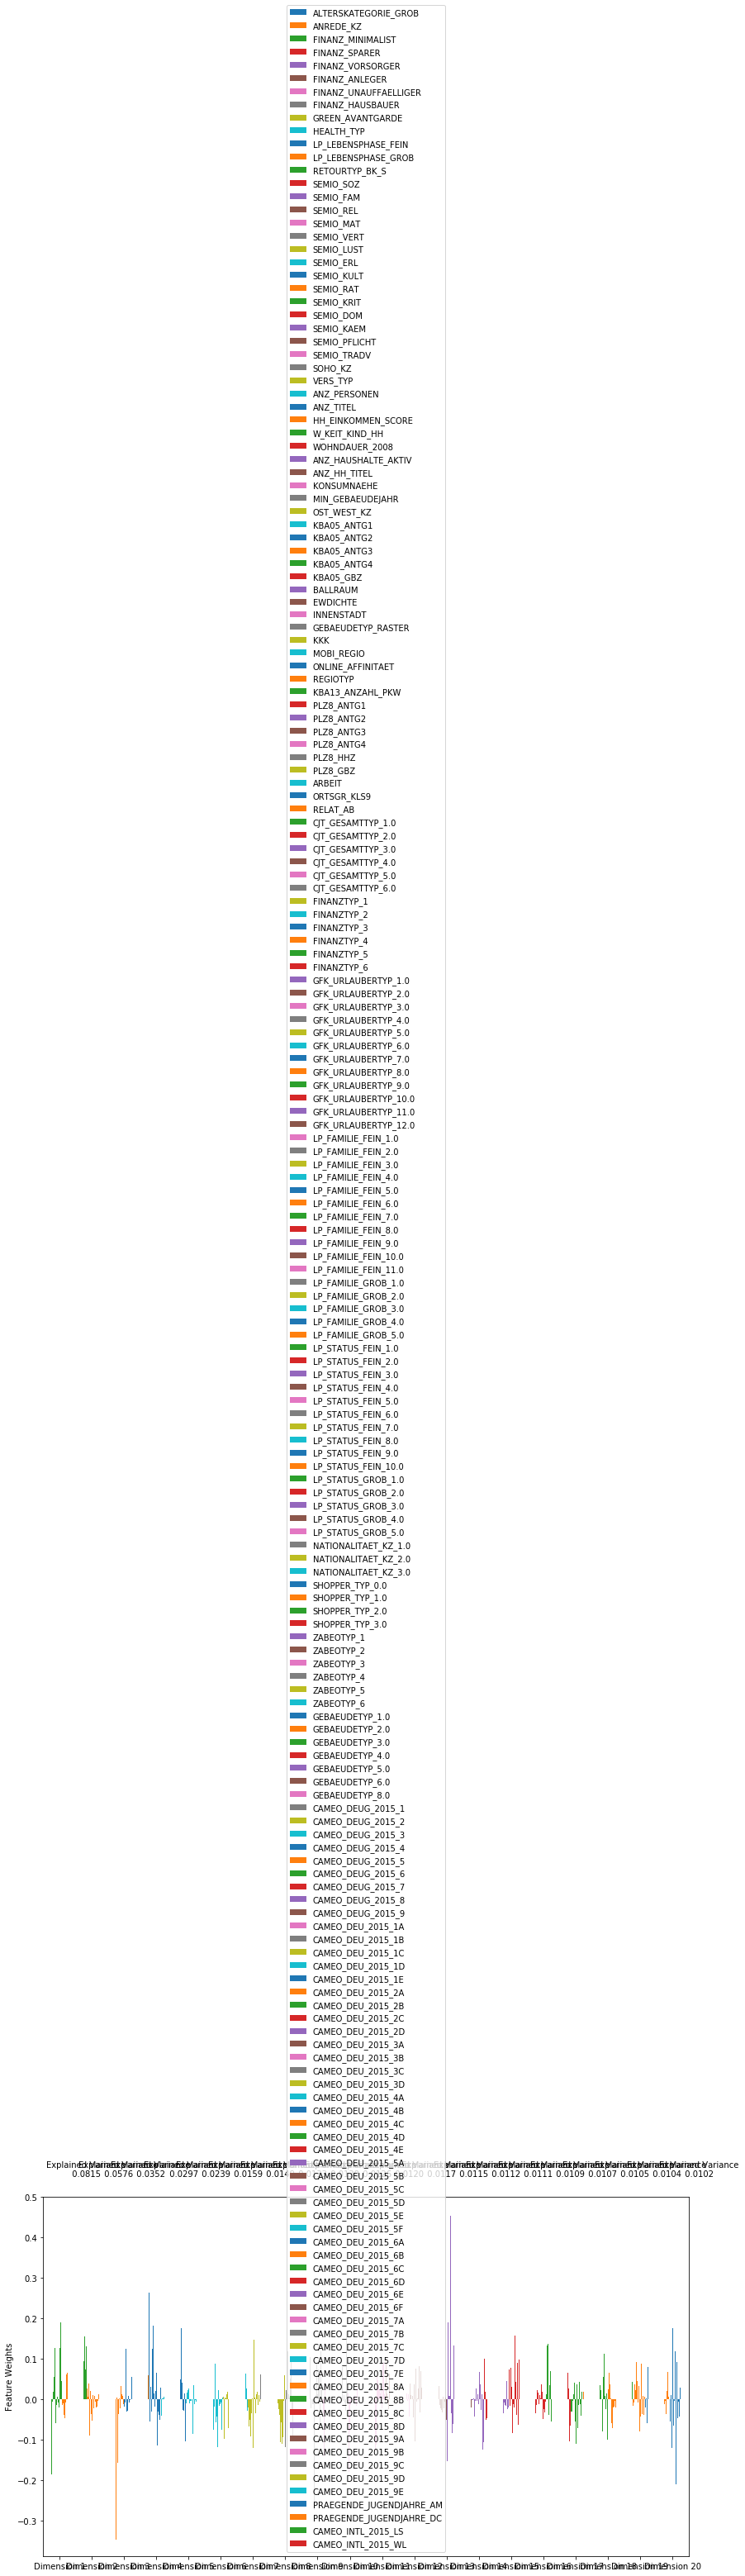

In [92]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca1 = PCA (n_components = 20)
azdias5_pca1 = pca1.fit_transform (azdias5)
pca_results (azdias5, pca1)

In [93]:
#cumulative variance
display (pca1.explained_variance_ratio_.sum ())

0.4078185927592769

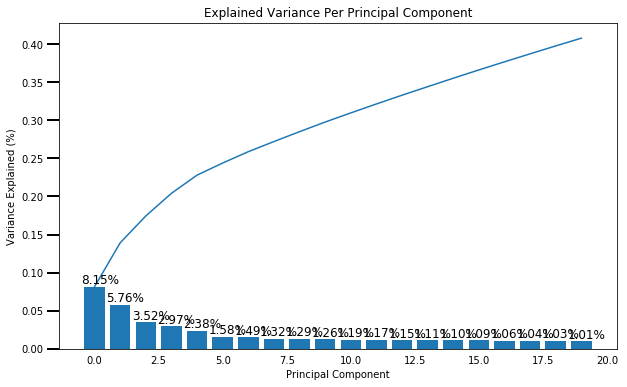

In [94]:
scree_plot (pca1)

### Discussion 2.2: Perform Dimensionality Reduction

I have applied sklearn's PCA class to apply principal component analysis on the data (selecting number of components to 100) so to find the vectors of maximal variance in the data. 
Checked the ratio of variance explained by each principal component and cumulative variance  using scree_plot. 
Since variance explained by 21st component onwards is less than 1% then I have decided to use 20 components to be used for PCA.
Which gives almost 41% of variance.  


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [95]:
df_comp=pd.DataFrame (pca1.components_)
df_comp.columns = azdias5.columns
display (df_comp)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL
0,-0.077441,0.014128,-0.185647,0.107561,-0.078096,0.049078,0.047311,0.148506,-0.104557,0.021938,...,0.025488,0.036289,0.055769,0.056811,0.056263,0.017416,-0.088595,0.065269,-0.106973,0.181234
1,0.235352,0.038687,0.094816,-0.229331,0.220401,-0.204006,-0.214207,0.079571,-0.004308,-0.052269,...,0.033516,-0.008676,-0.000187,0.004085,0.009962,0.038050,0.001310,-0.239994,0.016013,0.048620
2,0.016805,-0.346123,0.129822,-0.056702,0.047770,-0.153389,-0.047990,-0.061656,0.070625,-0.003816,...,0.000499,-0.003897,0.012846,0.025355,0.011740,-0.000989,0.055846,-0.049982,-0.015522,0.019023
3,0.006551,0.060663,-0.007159,-0.004588,0.010367,-0.047255,0.001856,0.004200,0.168542,-0.013862,...,0.001720,0.023092,0.011125,0.015959,0.011702,0.006779,0.161557,0.007051,-0.010297,0.017976
4,0.050147,-0.058580,0.018208,-0.028579,0.038652,0.050093,-0.112678,0.012833,-0.268011,0.004586,...,0.034931,0.050414,0.031194,0.012508,0.020017,-0.004390,-0.265583,-0.034561,-0.070943,0.138837
5,0.004806,0.002204,-0.127798,0.008831,0.029330,0.019361,0.022814,0.194674,-0.029993,-0.074705,...,0.006254,-0.040615,-0.071630,-0.060778,-0.070856,0.023994,-0.011845,-0.029225,0.061479,0.013683
6,0.014306,0.007771,0.068196,-0.017196,-0.037763,-0.016349,-0.024868,-0.117001,-0.051965,0.064901,...,-0.066580,0.000149,0.046527,0.062276,0.024217,0.068311,-0.054688,0.029522,-0.078085,-0.058789
7,0.007763,-0.013824,0.039721,-0.035851,-0.026070,-0.040609,-0.027247,-0.040762,-0.010028,0.027999,...,0.056516,-0.072722,-0.069486,-0.091549,-0.121620,-0.042797,-0.035478,0.017402,0.140000,0.009025
8,-0.043805,0.032603,-0.035694,0.029924,-0.078120,0.101718,-0.051369,0.105046,0.023893,-0.069648,...,0.085637,-0.000664,0.040860,0.006501,-0.021066,0.040661,0.032091,-0.004744,0.226318,-0.065664
9,-0.000126,-0.001660,-0.058117,0.010790,0.056674,0.013738,0.019791,0.081217,-0.038573,-0.040416,...,-0.016918,0.072386,0.030129,0.047825,0.067545,0.069340,-0.015800,-0.034317,-0.018633,-0.039362


In [96]:
def pc_feat (item, df):
    sorted_df = df.sort_values(df.index [item], axis=1)
      
    return sorted_df.iloc [[item]]
    

In [97]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

display (pc_feat (0,df_comp))


,MOBI_REGIO,KBA05_ANTG1,FINANZ_MINIMALIST,PLZ8_ANTG1,KBA05_GBZ,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,KONSUMNAEHE,PLZ8_GBZ,INNENSTADT,...,LP_STATUS_FEIN_1.0,KBA05_ANTG4,FINANZ_HAUSBAUER,EWDICHTE,ORTSGR_KLS9,PLZ8_ANTG4,PLZ8_ANTG3,CAMEO_INTL_2015_WL,HH_EINKOMMEN_SCORE,LP_STATUS_GROB_1.0
0,-0.201426,-0.186245,-0.185647,-0.178487,-0.177533,-0.147952,-0.134995,-0.133292,-0.12981,-0.123533,...,0.126464,0.126519,0.148506,0.148995,0.150183,0.171721,0.177769,0.181234,0.184494,0.19151


In [98]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

display (pc_feat (1, df_comp))


,PRAEGENDE_JUGENDJAHRE_DC,FINANZ_SPARER,SEMIO_REL,FINANZ_UNAUFFAELLIGER,SEMIO_TRADV,SEMIO_PFLICHT,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_KULT,ONLINE_AFFINITAET,...,FINANZ_MINIMALIST,FINANZTYP_5,CJT_GESAMTTYP_2.0,W_KEIT_KIND_HH,RETOURTYP_BK_S,SEMIO_LUST,SEMIO_ERL,ZABEOTYP_3,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB
1,-0.239994,-0.229331,-0.215545,-0.214207,-0.209557,-0.207757,-0.204006,-0.17007,-0.166702,-0.163017,...,0.094816,0.09617,0.110076,0.13073,0.155974,0.164903,0.181562,0.200057,0.220401,0.235352


In [99]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

display (pc_feat (2, df_comp))

,ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_ERL,SEMIO_RAT,FINANZ_ANLEGER,SHOPPER_TYP_2.0,FINANZTYP_1,LP_STATUS_FEIN_2.0,...,SEMIO_MAT,SEMIO_REL,ZABEOTYP_1,SHOPPER_TYP_0.0,FINANZ_MINIMALIST,FINANZTYP_5,SEMIO_KULT,SEMIO_SOZ,SEMIO_FAM,SEMIO_VERT
2,-0.346123,-0.316796,-0.284315,-0.265875,-0.207141,-0.155932,-0.153389,-0.107803,-0.101685,-0.081579,...,0.087911,0.11178,0.11539,0.124451,0.129822,0.135204,0.250424,0.258153,0.260173,0.320784


### Discussion 2.3: Interpret Principal Components

Principal component #1. 

Prominent features are: 
Negative: MOBI_REGIO (Movement patterns - region feature), KBA05_ANTG1 (Number of 1-2 family houses in the microcell), PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region), FINANZ_MINIMALIST (MINIMALIST: low financial interest) 

Positive: LP_STATUS_GROB_1.0 (Social status, rough scale), HH_EINKOMMEN_SCORE (Estimated household net income), PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region), CAMEO_INTL_2015_WL (Wealth of household).

From above I can presume that such factors as the most crucial such as movement level in the region, number of 1-2 houses in the microcell and region, social status, income, number 6-10 family houses in the region and wealth. It appears that the increases in 1-2 family houses will lead to decreases 6-10 family houses which is logical and confirmed by PCA. Increases in number of 1-2 family in microcell affects in increases of 1-2 family in the region.  

Principal component #2. 

Prominent features are: 
Negative: PRAEGENDE_JUGENDJAHRE_DC (person's youth in decades),	FINANZ_SPARER (financial typology - money saver), SEMIO_REL (religious)

Positive: ALTERSKATEGORIE_GROB (Estimated age), FINANZ_VORSORGER (financial typology - be prepared), ZABEOTYP_3 (Energy consumption typology).

From above I can presume that such factors as the most crucial such as youth in decades/age, financial typology, religious factor and energey consumption typology. It is also visible here that the more increases money saver then be prepared decreases as they are negatively correlated between each other. I can also conclude that religious factor is in accordance with money saver typology, from life experience I can also confirm that major religious are not supporting money wasting. 

Principal component #3. 

Prominent features are: 
Negative: ANREDE_KZ (Gender), SEMIO_KAEM (personal typology -combative attitude), SEMIO_DOM (personal typology -dominant-minded)

Positive: SEMIO_VERT (personal typology - dreamful), SEMIO_SOZ (personal typology - socially-minded), SEMIO_FAM (personal typology- family-minded). 

Both gender and personal typology closely related to each other being characteristic of a human. From the same negative direction we can see their correlation: gender factor, combative-dominant are in syncronization where factors increase together. From the other hand antagonists of combative and dominant-minded are dreamful, socially-minded and family-minded which also confirmed by PCA component.  


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [100]:
#defining function that was given during the course.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data)) #absolute value taken
    
    return score

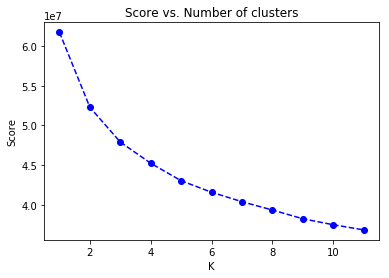

In [101]:
# Over a number of different cluster counts...
scores = []
centers = list(range(1,12))

for center in centers:
    scores.append(get_kmeans_score(azdias5_pca1, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Score');
plt.title('Score vs. Number of clusters');


    # run k-means clustering on the data and...
   
    # compute the average within-cluster distances.
    
   

In [102]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [103]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans (n_clusters = 5) 

model = kmeans.fit (azdias5_pca1) #fitting to the data

azdias_clust = model.predict (azdias5_pca1) #returning array of indeces for the cluster each sample belongs to.

#display (pd.DataFrame (azdias_clust))

### Discussion 3.1: Apply Clustering to General Population

I have prepaed a plot that reflects correlation between number of clusters and score (average distance to the from points of a cluster to cluster's centroid). 
Using elbow method I came to conclusion that 5 clusters should be a good decision since further from that score is not decreasing as much fast as looking into less number of clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [104]:
# Load in the customer demographics data.
customers = pd.read_csv ('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [105]:
display (customers.head (n=5))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [106]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cl, cust_dropped_rows, rows_number, cust_index, cust_df_out = clean_data(customers)


In [107]:
display (customers_cl.head (n=5))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,1.0,50.0,3.0,1.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,1.0,50.0,4.0,3.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,40.0,4.0,2.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,0.0,70.0,1.0,4.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,1.0,50.0,4.0,3.0


## Customer data cleaning results
What immediately appeared to me is that number of columns after clear processing (195) differs from the datafram of general population (196), so I was looking in the code where exactly 1 column left. 
It appeared that the difference caused by one-hot-encoding where for feature GEBAEUDETYP value of '5' is missing in the customer data comparing to general population. 
I found it looking at unique values for categorical features and comparing them to the same list of general population.

From this I can conclude that pure company buildings are not present in the customer data comparing to general population, it should be noted that mixed buildings presented in customer data.

In [108]:
for column in (cat_feat ['attribute']):
    print (column) #printing feature name
    unv = customers [column].unique () #returns list of unique values
    display (unv)

ANREDE_KZ


array([1, 2])

CJT_GESAMTTYP


array([  5.,  nan,   2.,   6.,   4.,   1.,   3.])

FINANZTYP


array([2, 6, 5, 3, 1, 4])

GFK_URLAUBERTYP


array([  4.,  nan,   3.,  10.,   2.,  11.,   8.,   1.,   5.,   9.,  12.,
         7.,   6.])

GREEN_AVANTGARDE


array([1, 0])

LP_FAMILIE_FEIN


array([  2.,  nan,   1.,  10.,   8.,   6.,  11.,   9.,   7.,   5.,   3.,
         4.])

LP_FAMILIE_GROB


array([  2.,  nan,   1.,   5.,   4.,   3.])

LP_STATUS_FEIN


array([ 10.,  nan,   9.,   1.,   7.,   6.,   3.,   5.,   8.,   4.,   2.])

LP_STATUS_GROB


array([  5.,  nan,   4.,   1.,   3.,   2.])

NATIONALITAET_KZ


array([  1.,   2.,  nan,   3.])

SHOPPER_TYP


array([  3.,   1.,   0.,   2.,  nan])

SOHO_KZ


array([  0.,  nan,   1.])

VERS_TYP


array([  1.,   2.,  nan])

ZABEOTYP


array([3, 1, 2, 4, 6, 5])

GEBAEUDETYP


array([  1.,  nan,   8.,   2.,   3.,   4.,   6.])

OST_WEST_KZ


array(['W', nan, 'O'], dtype=object)

CAMEO_DEUG_2015


array(['1', nan, '5', '4', '7', '3', '9', '2', '6', '8'], dtype=object)

CAMEO_DEU_2015


array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D'], dtype=object)

In [109]:
#Adding missing column GEBAEUDETYP_5.0 so to re-use PCA models fitted to general population  

customers_cl.insert (loc = 136, column = 'GEBAEUDETYP_5.0', value = 0) #filling with zeroes since value of 5 is not presented

#pd.set_option('display.max_columns', None)
#display (customers_cl ['GEBAEUDETYP_4.0'].head (n=5))
#display (customers_cl .head (n=5))

#display (customers_cl.columns.get_loc ('GEBAEUDETYP_4.0'))
#display (customers_cl.columns.get_loc ('GEBAEUDETYP_5.0'))
#display (customers_cl.columns.get_loc ('GEBAEUDETYP_6.0'))
#display (customers_cl.columns.get_loc ('GEBAEUDETYP_8.0'))

In [110]:
#features scaling 

#customers_cl5 = pd.DataFrame (scaler.fit_transform (customers_cl))
customers_cl5 = pd.DataFrame (scaler.transform (customers_cl))
customers_cl5.columns = customers_cl.columns #restoring column names
customers_cl5.index = customers_cl.index #restoring indeces


In [111]:
#PCA for customer data
customer_cl5_pca = pca1.transform (customers_cl5)

#customer_cl5_pca = pd.DataFrame (customer_cl5_pca) 
#customer_cl5_pca.columns = customers_cl5.columns #restoring column names
#customer_cl5_pca.index = customers_cl5.index #restoring indeces

In [112]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

customers_clust = model.predict (customer_cl5_pca) #returning array of indeces for the cluster each sample belongs to.

#display (pd.DataFrame (customers_clust))

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8a7731240>]], dtype=object)

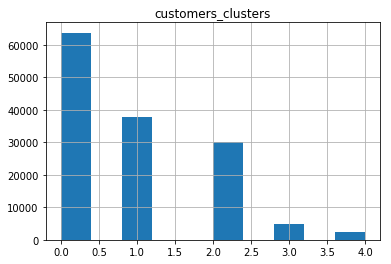

In [113]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cust_cldf = pd.DataFrame (customers_clust, columns = ['customers_clusters'])

cust_cldf.hist ()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8a86132b0>]], dtype=object)

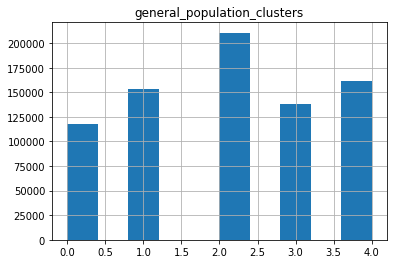

In [114]:
azdias_cldf = pd.DataFrame (azdias_clust, columns = ['general_population_clusters'])

azdias_cldf.hist ()

In [115]:
azdias_prop = pd.DataFrame (azdias_cldf.general_population_clusters.value_counts ())/ (azdias_new.shape [0]) * 100

#number of dropped rows where missing values were presented in more than 10 fields 
azdias_drop_number = (azdias_new2 [ azdias_new2 ['missing_in_rows'] >10].shape [0])/ (azdias_new.shape [0]) * 100

print (azdias_drop_number)

#adding dropped rows as separate cluster
value_toadd = pd.Series ([azdias_drop_number], index = ['general_population_clusters'])
azdias_prop = azdias_prop.append (value_toadd, ignore_index=True)

azdias_prop.sort_index (inplace = True)
display (azdias_prop)

print (azdias_prop.sum ())

12.462453196233033


,general_population_clusters
0,23.627473
1,18.086311
2,17.223337
3,15.438932
4,13.161494
5,12.462453


general_population_clusters    100.0
dtype: float64


In [116]:
customers_prop = pd.DataFrame (cust_cldf.customers_clusters.value_counts ())/ (rows_number) * 100

#adding dropped rows as separate cluster
additional_cluster = (cust_dropped_rows/ (rows_number)) * 100
print (additional_cluster)

value_toaddc = pd.Series ([additional_cluster], index = ['customers_clusters'])
customers_prop = customers_prop.append (value_toaddc, ignore_index=True)

customers_prop.sort_index (inplace = True)
display (customers_prop)

print (customers_prop.sum ())

27.437229979337552


,customers_clusters
0,33.269155
1,19.791080
2,15.676852
3,2.549934
4,1.275750
5,27.437230


customers_clusters    100.0
dtype: float64


In [117]:
#restoring indices for general population and applying them to clustered list, using the indeces 
#we can investigate rows of the original dataset
azdias_clust_inv = pd.DataFrame (azdias_clust, columns = ['clusters'])
azdias_clust_inv.index = azdias5.index #restoring indeces
display (azdias_clust_inv.tail (n=10))
print (azdias_clust_inv.shape)


,clusters
891211,2
891212,2
891213,0
891214,4
891215,4
891216,3
891217,2
891218,3
891219,4
891220,2


(780153, 1)


In [118]:
#restoring indices for customer population and applying them to clustered list, using the indeces 
#we can investigate rows of the original dataset
customers_clust_inv = pd.DataFrame (customers_clust, columns = ['clusters'])
customers_clust_inv.index = cust_index #restoring indeces
display (customers_clust_inv.tail (n=10))
print (customers_clust_inv.shape)


,clusters
191641,0
191642,2
191643,0
191644,2
191645,0
191646,2
191647,0
191649,0
191650,1
191651,1


(139068, 1)


### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

People from cluster /#5 are overpresented in the customer dataset, those supposed to be target audience for the company. 
Investigation of data presented in cluster /#5 reflected below.

In [119]:
#Data of cluster #5 was stored in cust_df_out

#cust_df_out.head (n=10)

display (pd.DataFrame (cust_df_out.median ()).transpose ())


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,6.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,2.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,3.0


## Investigation of cluster number 5 features (data with missing values in more than 10 fields)
Now let's check median values of below features which will characterize cluster 5.

What can we say about people that considered to be target audience:

MOBI_REGIO (movement in the region) low movement in the region.

KBA05_ANTG1 (Number of 1-2 family houses in the microcell) - average share of 1-2 family houses in the microcell.

FINANZ_MINIMALIST (MINIMALIST: low financial interest) - is average.

HH_EINKOMMEN_SCORE (Estimated household net income) - very high income.

PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region) - lower share of 6-10 family houses in the PLZ8 region.

CAMEO_INTL_2015_WL (Wealth of household) - Prosperous Households - Elders In Retirement.

FINANZ_SPARER (financial typology - money saver) - low.

FINANZ_VORSORGER (financial typology - be prepared) - is average.

SEMIO_REL (religious) - lowest affinity (almost not religious at all).

ALTERSKATEGORIE_GROB (Estimated age) - 30 - 45 years old

ANREDE_KZ (Gender) - Male

SEMIO_KAEM (personal typology -combative attitude) - very low, SEMIO_DOM (personal typology -dominant-minded) - very low, SEMIO_VERT (personal typology - dreamful)- highest affinity, SEMIO_SOZ (personal typology - socially-minded) - very high affinity, SEMIO_FAM (personal typology- family-minded)- very low affinity.

Summary
Typical person in the target group is a man, mid age (30-45) living in a household with very high income, almost not religious, he is not money saver, living in prosperous household (elders in retirement), perhaps he is living with his parents, in the microcell with average 1-2 families, in the region of low movement. He is not combatative, nor dominant. He is likely dreamful and socially-minded and very unlikely to be family-minded. 

### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

People from cluster /#4 are underpresented in the customer dataset
those supposed to be outside of target audience for the company

Investigation of data presented in cluster /#4 reflected below. 

In [120]:
#adding cluster column to the general population dataset
azdias6 = azdias_new4.join (azdias_clust_inv)
display (azdias6.head (n=6))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL,clusters
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0.0,90.0,1.0,5.0,4
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,1.0,90.0,4.0,2.0,3
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0.0,70.0,2.0,1.0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0.0,70.0,3.0,4.0,2
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0.0,50.0,4.0,5.0,3
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0.0,80.0,2.0,2.0,3


In [121]:
azdias7 = azdias6[ azdias6 ['clusters'] ==4]
display (azdias7.head (n=6))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL,clusters
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0.0,90.0,1.0,5.0,4
21,2.0,1,3,4,1,2,5,1,0,2.0,...,0,0,0,0,1,0.0,80.0,5.0,5.0,4
22,1.0,1,1,5,3,5,5,5,0,2.0,...,0,0,0,1,0,0.0,90.0,1.0,5.0,4
31,2.0,2,1,5,2,3,5,4,0,1.0,...,0,0,0,1,0,0.0,80.0,1.0,5.0,4
43,1.0,2,1,5,3,5,5,5,0,3.0,...,0,0,0,0,0,0.0,90.0,5.0,2.0,4
52,1.0,2,1,4,2,2,4,3,0,3.0,...,0,0,0,0,0,0.0,90.0,1.0,4.0,4


In [122]:
display (pd.DataFrame (azdias7.median ()).transpose ())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_AM,PRAEGENDE_JUGENDJAHRE_DC,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WL,clusters
0,2.0,2.0,1.0,5.0,2.0,4.0,4.0,4.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0,5.0,4.0


## Investigation of cluster number 4 features

Now let's check median values of below features which will characterize cluster 4.

What can we say about people that typically outside of target group: 

MOBI_REGIO (movement in the region) low movement in the region. 

KBA05_ANTG1 (Number of 1-2 family houses in the microcell) - average share of 1-2 family houses in the microcell.

FINANZ_MINIMALIST (MINIMALIST: low financial interest) - is high.  

HH_EINKOMMEN_SCORE (Estimated household net income) - average income. 

PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region) - lower share of 6-10 family houses in the PLZ8 region.

CAMEO_INTL_2015_WL (Wealth of household) - Prosperous households.

FINANZ_SPARER (financial typology - money saver) - low.

FINANZ_VORSORGER (financial typology - be prepared) - high, so mostly financial typology is "be prepared" which is above money saver but less than investor. 

SEMIO_REL (religious) - very low affinity.

ALTERSKATEGORIE_GROB (Estimated age) - 30 - 45 years old

ANREDE_KZ (Gender) - Female

SEMIO_KAEM (personal typology -combative attitude) - average
SEMIO_DOM (personal typology -dominant-minded) - average
SEMIO_VERT (personal typology - dreamful)- average
SEMIO_SOZ (personal typology - socially-minded) - average
SEMIO_FAM (personal typology- family-minded)- low. 

### Summary

Typical person outside of target group is a woman, mid age (30-45) with average income, low affinity to religious, she is not money saver, living in prosperous household, in the microcell with average 1-2 families, in the region of low movement. Personal typology. She can be in average combatative/dominant, dremful, socially-minded with lower probability for family-minded. We can say this is a person modern, active, which can stands for his rights and needs.

From previous observations I can also add that pure company buildings are not present in the customer data comparing to general population, at the same time it should be noted that mixed buildings presented in customer data.

### Discussion 3.3: Compare Customer Data to Demographics Data

Above I have described typical image of a person for whom this particular company would be popular and vice-versa. Intresting findings are that there is a segregation between man/woman, personal typology, income between these groups.
It means that the difference between them prominent and actions can be taken from the company management to focus on the target group of general population so to increase income of the company. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.